In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel
# from sepObjectiveGO import getObjective as gO
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
from protein.LipidLeafletWithProtein_builtOn3 import LipidLeafletWithProtien as LipidLeaflet
from protein.protrusion2 import Protrusion

from refnx._lib import flatten
from refnx._lib import unique as f_unique

print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting
csv
cvs-collecting
csv
cvs-collecting


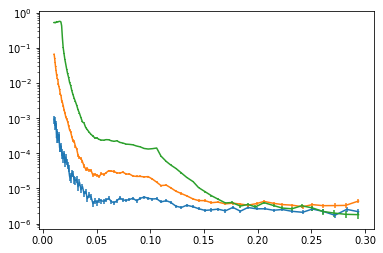

In [2]:
# dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
# dataD2o.name="d2o"
# dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
# dataPmw.name="pmw"

dataAcmw = Data1D(data=di.data_in("protein/54613_14edit.txt"))
dataAcmw.name="acm"
dataPmw = Data1D(data=di.data_in("protein/54616_17edit.txt"))
dataPmw.name="pmw"
dataD2o = Data1D(data=di.data_in("protein/10_11_d2o.txt"))
dataD2o.name="d2o"
plt.errorbar(dataAcmw.data[0],dataAcmw.data[1],dataAcmw.data[2])
plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.yscale("log")
plt.show()

In [3]:
name = "bilayer"

d2o = SLD(6.34, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
acmw = SLD(0.00, "ACMW")
air = SLD(0.00, "Air")

d2o.real.setp(vary=True, bounds=(5.35, 6.35)) # bounds=(5.9, 6.35))
pmw.real.setp(vary=True, bounds=(1.35, 3.35))
acmw.real.setp(vary=True, bounds=(-0.56, 1))

apm = Parameter(value=101, name='%s - area_per_molecule' % name,
                bounds=(100, 150), vary=True)

#Define all the neutron b's
bc = 0.6646e-4  #Carbon
bo = 0.5804e-4  #Oxygen
bh = -0.3739e-4 #Hydrogen
bp = 0.513e-4   #Phosphorus
bn = 0.936e-4   #Nitrogen
bd = 0.6671e-4  #Deuterium

#Formulae of the molecule sections...
CH2 = (1*bc) + (2*bh)
CH = (1*bc) + (1*bh)
CH3 = (1*bc) + (3*bh)
D2O = (2*bd) + (1*bo)
H2O = (2*bh) + (1*bo)

# Calculate mole fraction of D2O from the bulk SLD..
# d2o_molfr = (1/D2O-H2O)*(contrast*27.64)-H2O
# wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

#sum b's of all the different fragments
b_tails = Parameter(value=(28*CH2) + (2*CH) + (2*CH3),
                       name='%s - b_tails_real' % name)

sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
b_heads = Parameter(value=(3*(sum_popc_heads) + (sum_popg_heads))/4,
                        name='%s - b_heads_real' % name)

#monolayer compositions
#sum_m_tails = (34*CH2) + (2*CH3);
#sum_m_heads = (1*bn) + (2*CH3) + (Waters_per_headD * wMol);

#volumes of each fragment
vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
vm_tails = Parameter(value=(nCH2 * vCH2) + (2 * vCH3),
            name='%s - volume_tails' % name) #
vm_heads = Parameter(value=331,
            name='%s - volume_heads' % name)  #
vm_water = Parameter(value=29.7,
            name='%s - water_vm' % name)

#thickness
thickness_tails = Parameter(11, # 6., #value=vm_tails.value/apm.value,
            name='%s - thickness_tails' % name,
            bounds=(1,30),  #3, #(1-0.75)*vm_tails.value/apm.value,
                      #9), #(1+0.75)*vm_tails.value/apm.value),
               vary=True)
thickness_heads = Parameter(value= 6, #11., #vm_heads.value/apm.value,
            name='%s - thickness_heads' % name,
            bounds=(1,30),  #  9, #(1-0.75)*vm_heads.value/apm.value,
                      # 20), #(1+0.75)*vm_heads.value/apm.value),
               vary=True)

rough_top = Parameter(value=2,
            name='%s - roughs' % name,
            bounds=(0,10), vary=True)
rough_bot = rough_top
# rough_bot = Parameter(value=2.0,
#             name='%s - rough_bot' % name,
#             bounds=(0,10), vary=True)

waters_per_head = Parameter(
            value=2.8,
            name="{} - Waters Per Head".format(name),
            bounds=(0, 20), vary=True)

waters_per_tail = Parameter(
            value=1,
            name="{} - Waters Per Tail".format(name),
            bounds=(0, 10), vary=True)

# b_mscl = Parameter(
#             value= ,
#             name="{} - b_protein_real".format(name),
#             vary=False)

vm_mscl = Parameter(
            value=74937.5, # + 19749
            name="{} - volume_protein".format(name),
            vary=False)

PLRatio = Parameter(
            value= 0.75,
            name="{} - ratio protein to bilayer".format(name),
            bounds=(0.5, 1),vary=True)

namePro = "Protrusion"
vol_protrusion = Parameter(
            value= 19749,
            name="{} - protien volume".format(namePro),
            vary=False)

protrusion_thick = Parameter(
            value= 20,
            name="{} - protrusion thickness".format(namePro),
            bounds=(5, 100),vary=True)

protrusion_rough = Parameter(
            value= 2,
            name="{} - protrusion roughness".format(namePro),
            bounds=(0, 20),vary=True)

protrusion_volfrac = Parameter(
            value= 0.5,
            name="{} - protrusion volfrac".format(namePro),
            bounds=(0, 1),vary=True)


In [4]:
# apm, b_heads, vm_heads, thickness_heads
# b_tails, vm_tails, thickness_tails, rough_head_tail
# rough_preceding_mono, head_solvent


# head_solvent_d2o = SLD(6.07, "D2O in bilayer")
# head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
upper_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, d2o, d2o,
    reverse_monolayer=False, name="upper_lipid_d2o")

lower_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, d2o, d2o,
    reverse_monolayer=True, name="lower_lipid_d2o")

right_protrusion_d2o = Protrusion(thick=protrusion_thick,
    rough=protrusion_rough, vol_protein=vol_protrusion,
    PLratio=PLRatio, solventSLD=d2o,  name=namePro+" d2o",
    vfsolv=protrusion_volfrac)


# head_solvent_pmw = SLD(2.35, "Protein Matched Water in bilayer")
# head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
upper_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, pmw, pmw,
    reverse_monolayer=False, name="upper_lipid_pmw")

lower_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, pmw, pmw,
    reverse_monolayer=True, name="lower_lipid_pmw")

right_protrusion_pmw = Protrusion(thick=protrusion_thick,
    rough=protrusion_rough, vol_protein=vol_protrusion,
    PLratio=PLRatio, solventSLD=pmw,  name=namePro+" pmw",
    vfsolv=protrusion_volfrac)


upper_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, acmw, acmw,
    reverse_monolayer=False, name="upper_lipid_acmw")

lower_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, acmw, acmw,
    reverse_monolayer=True, name="lower_lipid_acmw")

right_protrusion_acmw = Protrusion(thick=protrusion_thick,
    rough=protrusion_rough, vol_protein=vol_protrusion,
    PLratio=PLRatio, solventSLD=acmw,  name=namePro+" acmw",
    vfsolv=protrusion_volfrac)

In [5]:
# name_m = "mono, dodab"
# APMD = Parameter(value=48, name='%s - area_per_molecule' % name_m,
#         bounds=(30,120), vary=True)

# # monolayer compositions
# m_tails = Parameter(value=(34*CH2) + (2*CH3),
#             name='%s - b_tails_real' % name_m)
# m_heads = Parameter(value=(1*bn) + (2*CH3),
#             name='%s - b_heads_real' % name_m)

# # monolayer volumes
# vm_m_tails = Parameter(value=vCH2*36,
#             name='%s - volume_tails' % name_m)
# vm_m_heads = Parameter(value=54.6,
#             name='%s - volume_heads' % name_m)

# # monolayer thicknesses
# tail_thick_m = Parameter(value=vm_m_tails.value / APMD.value,
#             name='%s - thickness_tails' % name_m,
#             bounds=((1-0.75)*vm_m_tails.value / APMD.value,
#                     (1+0.75)*vm_m_tails.value / APMD.value),
#                vary=True)
# head_thick_m = Parameter(value=vm_m_heads.value / APMD.value,
#             name='%s - thickness heads' % name_m,
#             bounds=((1-0.75)*vm_m_heads.value / APMD.value,
#                     (1+0.75)*vm_m_heads.value / APMD.value),
#                vary=True)

# roughness_m =  Parameter(value=5.8,
#             name='%s - roughness' % name_m,
#             bounds=(0,10), vary=True)


# water_vm_m = Parameter(value=vm_water,
#             name='%s - water_vm' % name_m)
# waters_per_head_m = Parameter(
#             value=2.8,
#             name="{} Waters Per Head".format(name_m),
#             vary=True,
#             bounds=(1, 20))
# waters_per_tail_m = Parameter(
#             value=0.,
#             name="{} Waters Per Tail".format(name_m),
#             vary=False)

In [6]:
# m_head_solvent_pmw=SLD(2.35, "mono, dodab - Protein Matched Water in head")
# m_head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
# m_air_in_tail=SLD(0, "mono, dodab - air in tail")

# dodab_pmw = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
#     thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
#     thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
#     rough_preceding_mono=roughness_m,
#     water_vm=vm_water, waters_per_head=waters_per_head_m,
#     waters_per_tail=waters_per_tail_m,
#     head_solvent=m_head_solvent_pmw, tail_solvent=m_air_in_tail) #mono

# m_head_solvent_d2o=SLD(6.07, "mono, dodab - D2O in head")
# m_head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
# dodab_d2o = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
#     thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
#     thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
#     water_vm=vm_water, waters_per_head=waters_per_head_m,
#     waters_per_tail=waters_per_tail_m,
#     rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_d2o,
#                          tail_solvent=m_air_in_tail) #mono

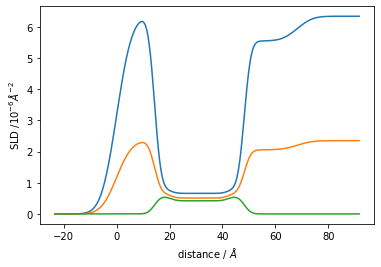

________________________________________________________________________________
Parameters: 'Structure - d2o'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 25]>
<Parameter:  'D2O - sld'  , value=6.34          , bounds=[5.35, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=4.6          , bounds=[0, 20]>
<Parameter:'D2O - volfrac solvent', value=0

<Parameter:'Protein Matched Water - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ACMW'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:     'ACMW'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 25]>
<Parameter: 'ACMW - sld'  , value=0          , bounds=[-0.56, 1]>
<Parameter: 'ACMW - isld' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_so

In [7]:
# structure_d2o = air(0, 0) | dodab_d2o | d2o(0, 0) | upper_lipid_d2o | lower_lipid_d2o | d2o(0, 0)
# structure_pmw = air(0, 0) | dodab_pmw | pmw(0, 0) | upper_lipid_pmw | lower_lipid_pmw | pmw(0, 0)
# structure_d2o = air(0, 0) | d2o(0, 0) | upper_lipid_d2o | lower_lipid_d2o | d2o(0, 0)
# structure_pmw = air(0, 0) | pmw(0, 0) | upper_lipid_pmw | lower_lipid_pmw | pmw(0, 0)
#
#
# solution_thickness = Parameter(value=14.3, bounds=(6, 20), vary=True,
#             name='%s - thickness_solution' % name)

# rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
#             name='%s - rough_preceding_solution' % name)
# 
# structure_d2o[2].thick=solution_thickness#.setp(14.3, vary=True, bounds=(6, 20))
# structure_d2o[2].rough=rough_preceding_solution#.setp(4.6, vary=True, bounds=(3, 20))
# structure_pmw[2].thick=solution_thickness
# structure_pmw[2].rough=rough_preceding_solution
#
# structure_d2o[5].thick=solution_thickness
# structure_d2o[5].rough=rough_preceding_solution
# structure_pmw[5].thick=solution_thickness
# structure_pmw[5].rough=rough_preceding_solution

# to changing to
solution_thickness = Parameter(value=14.3, bounds=(6, 25), vary=True,
            name='thickness_solution')

rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
            name='rough_preceding_solution')

structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | upper_lipid_d2o  | lower_lipid_d2o  | right_protrusion_d2o  | d2o(solution_thickness, rough_preceding_solution)
structure_pmw  = air(0, 0) | pmw(solution_thickness, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | right_protrusion_pmw  | pmw(solution_thickness, rough_preceding_solution)
structure_acmw = air(0, 0) | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | right_protrusion_acmw | acmw(solution_thickness, rough_preceding_solution)

# structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | upper_lipid_d2o  | lower_lipid_d2o  | d2o(solution_thickness, rough_preceding_solution)
# structure_pmw  = air(0, 0) | pmw(solution_thickness, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | pmw(solution_thickness, rough_preceding_solution)
# structure_acmw = air(0, 0) | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | acmw(solution_thickness, rough_preceding_solution)

structure_d2o.name = "d2o"
structure_pmw.name = "protein matched water"
structure_acmw.name = "ACMW"

plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.show();
print(structure_d2o.parameters)
print(structure_pmw.parameters)
print(structure_acmw.parameters)

In [8]:
right_protrusion_d2o.parameters

Parameters(data=[Parameter(value=20.0, name='Protrusion - protrusion thickness', vary=True, bounds=Interval(lb=5, ub=100), constraint=None), Parameter(value=2.0, name='Protrusion - protrusion roughness', vary=True, bounds=Interval(lb=0, ub=20), constraint=None), Parameter(value=19749.0, name='Protrusion - protien volume', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.5, name='Protrusion - protrusion volfrac', vary=True, bounds=Interval(lb=0, ub=1), constraint=None)], name='Protrusion d2o')

In [9]:
# print(structure_acmw.slabs())
# print(structure_pmw.slabs())
# print(structure_d2o.slabs())

In [10]:
scale = 0.5538
print(dataD2o.y.max(), dataPmw.y.max(), dataAcmw.y.max())
print(dataD2o.y.min(), dataPmw.y.min(), dataAcmw.y.min())
model1 = ReflectModel(structure_d2o)
model1.scale.setp(scale, vary=False) # 0.5, vary=True, bounds=(0.5, 0.6))#0.25, 1)) #1./dataD2o.y.max()
if dataD2o.y.min()<0:
    d2oUpBound = dataD2o.y.min() * 0.2
    d2oLoBound = dataD2o.y.min() * 1.8
else:
    d2oUpBound = dataD2o.y.min() * 1.8
    d2oLoBound = dataD2o.y.min() * 0.2
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(d2oLoBound, d2oUpBound))

model2 = ReflectModel(structure_pmw)
model2.scale.setp(scale, vary=False) #0.5, vary=True, bounds=(0.5, 0.6))#0.25, 1))#(1./dataPmw.y.max(), vary=False)
if dataPmw.y.min()<0:
    pmwUpBound = dataPmw.y.min() * 0.2
    pmwLoBound = dataPmw.y.min() * 1.8
else:
    pmwUpBound = dataPmw.y.min() * 1.8
    pmwLoBound = dataPmw.y.min() * 0.2
model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(pmwLoBound, pmwUpBound))

model3 = ReflectModel(structure_acmw)
model3.scale.setp(scale, vary=False) #0.5, vary=True, bounds=(0.5, 0.6))#0.25, 1)) #1./dataAcmw.y.max(), vary=False)
if dataAcmw.y.min()<0:
    acmwUpBound = dataAcmw.y.min() * 0.2
    acmwLoBound = dataAcmw.y.min() * 1.8
else:
    acmwUpBound = dataAcmw.y.min() * 1.8
    acmwLoBound = dataAcmw.y.min() * 0.2
model3.bkg.setp(dataAcmw.y.min(),vary=True,bounds=(acmwLoBound, acmwUpBound))

objective1 = Objective(model1, dataD2o, transform=Transform("logY"))
objective2 = Objective(model2, dataPmw, transform=Transform("logY"))
objective3 = Objective(model3, dataAcmw, transform=Transform("logY"))
gobjective = GlobalObjective([objective1,objective2,objective3])

0.562 0.0655 0.000924
1.8e-06 3.02e-06 1.73e-06


In [11]:
print("")
print("logp:",gobjective.logp())
[[print(i,param.name+":",param.value, param.bounds,"logp:", param.logp())] for i,param in enumerate(gobjective.varying_parameters())];



logp: -inf
0 bkg: 1.8e-06 [3.6e-07, 3.24e-06] logp: 12.75772026381642
1 thickness_solution: 14.3 [6, 25] logp: -2.9444389791664407
2 D2O - sld: 6.34 [5.35, 6.35] logp: 0.0
3 rough_preceding_solution: 4.6 [0, 20] logp: -2.995732273553991
4 bilayer - area_per_molecule: 609.5392647058824 [100, 150] logp: -inf
5 bilayer - thickness_heads: 6.0 [1, 30] logp: -3.367295829986474
6 bilayer - thickness_tails: 11.0 [1, 30] logp: -3.367295829986474
7 bilayer - roughs: 2.0 [0, 10] logp: -2.3025850929940455
8 bilayer - Waters Per Head: 2.8 [0, 20] logp: -2.995732273553991
9 bilayer - Waters Per Tail: 1.0 [0, 10] logp: -2.3025850929940455
10 bilayer - ratio protein to bilayer: 0.75 [0.5, 1] logp: 0.6931471805599453
11 Protrusion - protrusion thickness: 20.0 [5, 100] logp: -4.553876891600541
12 Protrusion - protrusion roughness: 2.0 [0, 20] logp: -2.995732273553991
13 Protrusion - protrusion volfrac: 0.5 [0, 1] logp: 0.0
14 bkg: 3.02e-06 [6.040000000000001e-07, 5.436e-06] logp: 12.24025009733176
15 P

In [12]:
%%time
choose = 0
if choose==0:
    fitter = CurveFitter(gobjective)
    res = fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)
if choose==1:
    fitter = CurveFitter(gobjective)
    fitter.sample(400)
    fitter.reset()
    res = fitter.sample(15, nthin=100)
if choose==2:
    from dynesty import DynamicNestedSampler
    from dynesty import plotting as dyplot
    from CFitter import CFitter
    fitter = CFitter(gobjective)
    # DynamicNestedSampler
    DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
    DNSampler.run_nested(dlogz_init=0.05) # was 0.01
    res1 = DNSampler.results
print("done")

done
Wall time: 11min 55s


In [13]:
# print(gobjective.parameters,"\n++++++++++++++++++++++++++++++++++++++++++++++++++++")

# [[print(param)] for param in gobjective.parameters]#varying_parameters()]

[[print(param)] for param in gobjective.varying_parameters()];

<Parameter:     'bkg'     , value=1.51274e-06 +/- 3.63e-07, bounds=[3.6e-07, 3.24e-06]>
<Parameter:'thickness_solution', value=11.1398 +/- 0.514, bounds=[6, 25]>
<Parameter:  'D2O - sld'  , value=6.10782 +/- 0.00578, bounds=[5.35, 6.35]>
<Parameter:'rough_preceding_solution', value=3.78517 +/- 2.04 , bounds=[0, 20]>
<Parameter:'bilayer - area_per_molecule', value=119.277 +/- 1.59e-07, bounds=[100, 150]>
<Parameter:'bilayer - thickness_heads', value=1.00392 +/- 1.64 , bounds=[1, 30]>
<Parameter:'bilayer - thickness_tails', value=20.141 +/- 1.35 , bounds=[1, 30]>
<Parameter:'bilayer - roughs', value=5.92215 +/- 1.47 , bounds=[0, 10]>
<Parameter:'bilayer - Waters Per Head', value=19.4598 +/- 1.1e+03, bounds=[0, 20]>
<Parameter:'bilayer - Waters Per Tail', value=0.138108 +/- 1.06e+03, bounds=[0, 10]>
<Parameter:'bilayer - ratio protein to bilayer', value=0.974037 +/- 0.33 , bounds=[0.5, 1]>
<Parameter:'Protrusion - protrusion thickness', value=8.67889 +/- 54.1 , bounds=[5, 100]>
<Parameter

In [14]:
if choose==2:
    print(res1)
else:
    print(res)
# [['bkg', nan],
#  ['thickness_solution', nan],
#  ['D2O - sld', nan],
#  ['rough_preceding_solution', nan],
#  ['bilayer - area_per_molecule', nan],
#  ['bilayer - thickness_heads', nan],
#  ['bilayer - thickness_tails', nan],
#  ['bilayer - rough_top', nan],
#  ['bilayer - Waters Per Head', nan],
#  ['bilayer - Waters Per Tail', nan],
#  ['bilayer - ratio protein to bilayer', nan],
#  ['bkg', nan],
#  ['Protein Matched Water - sld', nan],
#  ['bkg', nan],
#  ['ACMW - sld', nan]]

   covar: array([[ 1.31914849e-13, -2.70090202e-08,  1.34032884e-10,
         5.30081243e-07, -1.72914505e-14,  3.04678458e-07,
        -2.70187367e-07, -1.74589186e-07,  1.24184467e-04,
         1.15702542e-04,  3.92075863e-08, -1.23079063e-05,
         5.17420211e-07, -1.51539373e-06,  1.27845425e-14,
        -4.16175353e-11,  1.01678123e-14, -3.25226378e-10],
       [-2.70090202e-08,  2.63782856e-01,  1.21406149e-04,
        -4.10732268e-01,  7.92033860e-08, -5.69356720e-01,
         3.52745671e-01,  3.14248226e-01, -5.46408471e+02,
        -5.28480583e+02, -1.63166073e-01,  1.26499411e+01,
        -1.31011504e+00,  6.51804029e+00, -1.47376173e-08,
         5.38191500e-04, -1.99931525e-08,  3.91354799e-03],
       [ 1.34032884e-10,  1.21406149e-04,  3.33714843e-05,
         2.01463211e-03, -8.88670880e-12,  1.13515926e-03,
        -1.02255226e-03, -1.57784753e-03,  7.30948794e-02,
         4.85346846e-02,  1.91270100e-05, -3.47084776e-02,
         1.65844725e-03,  2.37811580e-03,  1

In [15]:
print(structure_acmw.slabs())
print(structure_pmw.slabs())
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.11397592e+01  3.90727517e-01  0.00000000e+00  3.78517096e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.54384568e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -7.19700697e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -7.19700697e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.54384568e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 8.67888626e+00  3.80936986e-01  0.00000000e+00  8.72701556e+00
   3.48709492e-02]
 [ 1.11397592e+01  3.90727517e-01  0.00000000e+00  3.78517096e+00
   0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.11397592e+01  1.75257245e+00  0.00000000e+00  3.78517096e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.58569868e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -6.78999028e-02  2.47020944e-11  5.92215211e+0

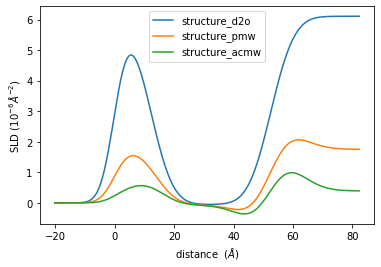

In [16]:
# structure_d2o
# structure_pmw
plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
# structure_d2o.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')
plt.legend()
plt.show();

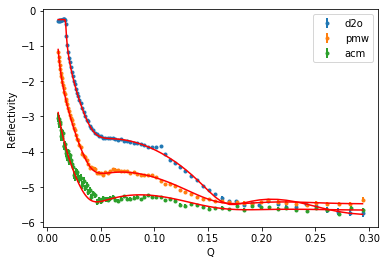

In [17]:
if choose==1:
    gobjective.plot(samples=300)
else:
    gobjective.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

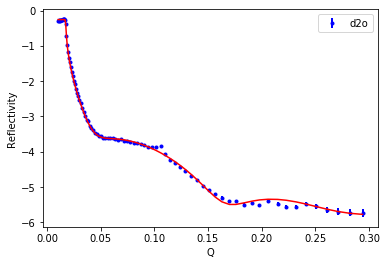

In [18]:
if choose==1:
    objective1.plot(samples=300)
else:
    objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

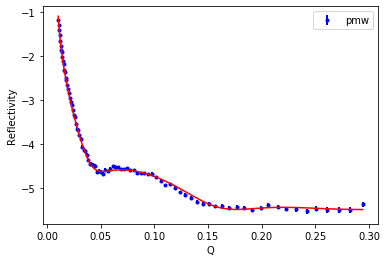

In [19]:
if choose==1:
    objective2.plot(samples=300)
else:
    objective2.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

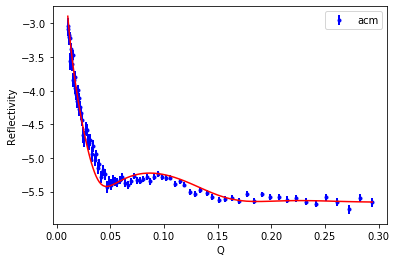

In [20]:
if choose==1:
    objective3.plot(samples=300)
else:
    objective3.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [21]:
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)
print("model3: acmw", model3.scale, model3.bkg)

model1: d2o <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=1.51274e-06 +/- 3.63e-07, bounds=[3.6e-07, 3.24e-06]>
model2: pmw <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=3.32753e-06 +/- 9.33e-08, bounds=[6.040000000000001e-07, 5.436e-06]>
model3: acmw <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=2.20064e-06 +/- 8.26e-08, bounds=[3.46e-07, 3.114e-06]>


In [22]:
# print(structure_d2o)

In [23]:
# print(structure_pmw)

In [24]:
# print(structure_acmw)

In [25]:
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.11397592e+01  6.10781983e+00  0.00000000e+00  3.78517096e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.71954665e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -5.48833081e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -5.48833081e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.71954665e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 8.67888626e+00  5.95477260e+00  0.00000000e+00  8.72701556e+00
   3.48709492e-02]
 [ 1.11397592e+01  6.10781983e+00  0.00000000e+00  3.78517096e+00
   0.00000000e+00]]


In [26]:
print(structure_pmw.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.11397592e+01  1.75257245e+00  0.00000000e+00  3.78517096e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.58569868e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -6.78999028e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -6.78999028e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.58569868e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 8.67888626e+00  1.70865734e+00  0.00000000e+00  8.72701556e+00
   3.48709492e-02]
 [ 1.11397592e+01  1.75257245e+00  0.00000000e+00  3.78517096e+00
   0.00000000e+00]]


In [27]:
print(structure_acmw.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.11397592e+01  3.90727517e-01  0.00000000e+00  3.78517096e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.54384568e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -7.19700697e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 2.01410308e+01 -7.19700697e-02  2.47020944e-11  5.92215211e+00
   0.00000000e+00]
 [ 1.00391960e+00  5.54384568e+00 -2.10876375e-07  5.92215211e+00
   0.00000000e+00]
 [ 8.67888626e+00  3.80936986e-01  0.00000000e+00  8.72701556e+00
   3.48709492e-02]
 [ 1.11397592e+01  3.90727517e-01  0.00000000e+00  3.78517096e+00
   0.00000000e+00]]


In [28]:
if choose==2:
    # span = [(0,5000),(0,1.5),(0,0.4),(-10**3,10**3)] #span=span
    fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                               logplot=False)

In [29]:
if choose==2:
    print("max(-ln(X)) =", -min(res1["logvol"])) # -min(res1["logvol"] = max(-ln(X))
    print("max(logz), evidence =", max(res1["logz"]))

In [30]:
#gobjective.varying_parameters()
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)
print("model3: acmw", model3.scale, model3.bkg)
[[print(i,param.name+":",param.value, param.bounds)] for i,param in enumerate(gobjective.varying_parameters())];

model1: d2o <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=1.51274e-06 +/- 3.63e-07, bounds=[3.6e-07, 3.24e-06]>
model2: pmw <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=3.32753e-06 +/- 9.33e-08, bounds=[6.040000000000001e-07, 5.436e-06]>
model3: acmw <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=2.20064e-06 +/- 8.26e-08, bounds=[3.46e-07, 3.114e-06]>
0 bkg: 1.5127444618966676e-06 [3.6e-07, 3.24e-06]
1 thickness_solution: 11.139759184593196 [6, 25]
2 D2O - sld: 6.107819832561563 [5.35, 6.35]
3 rough_preceding_solution: 3.7851709551739052 [0, 20]
4 bilayer - area_per_molecule: 118.23033489237058 [100, 150]
5 bilayer - thickness_heads: 1.0039196014745073 [1, 30]
6 bilayer - thickness_tails: 20.14103079899459 [1, 30]
7 bilayer - roughs: 5.922152114337889 [0, 10]
8 bilayer - Waters Per Head: 19.459809533446002 [0

I believe correct values, leaflet roughness between head and tail is the same as the roughness preceeding the leaflet\
class used is a modified version of the LipidLeaflet class native to refnx, its in the file\
"protein" and called "LipidLeafletWithProtien"\
volumes of head and tails are indirectly varied by changes in waters per head/tail\
so the tails do not change volume\
0 scale: 0.5521883304658243 [0.5, 0.6]\
1 bkg: 3.8668280301251303e-07 [3.6e-07, 3.24e-06]\
2 thickness_solution: 10.788185214150985 [6, 25]\
3 D2O - sld: 6.120774383877097 [5.35, 6.35]\
4 rough_preceding_solution: 3.939327435493368 [0, 20]\
5 bilayer - area_per_molecule: 149.83843268748353 [60, 150]\
6 bilayer - thickness_heads: 2.2131024442953855 [1, 30]\
7 bilayer - thickness_tails: 19.19114563662231 [1, 30]\
8 bilayer - rough_top: 0.15555337800548585 [0, 10]\
9 bilayer - Waters Per Head: 0.017922237590786594 [0, 20]\
10 bilayer - Waters Per Tail: 0.02927203409960022 [0, 10]\
11 bilayer - ratio protein to bilayer: 0.7498017765068212 [0.25, 0.75]\
12 Protrusion - protrusion thickness: 6.090177488208205 [5, 100]\
13 Protrusion - protrusion roughness: 7.445463122283828 [0, 20]\
14 Protrusion - protrusion volfrac: 0.9963095809664922 [0, 1]\
15 scale: 0.5990025735918081 [0.5, 0.6]\
16 bkg: 3.5880504074107574e-06 [6.040000000000001e-07, 5.436e-06]\
17 Protein Matched Water - sld: 1.757984633375042 [1.35, 3.35]\
18 scale: 0.5907367476195101 [0.5, 0.6]\
19 bkg: 2.831535701386751e-06 [3.46e-07, 3.114e-06]\
20 ACMW - sld: 0.4132210895757328 [-0.56, 1]

In [31]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.traceplot(res1, labels = labels, #truths=np.zeros(fitter.nDim()),
                                 show_titles=True, trace_cmap='plasma',
                                 quantiles=[0.025, 0.5, 0.975])
    fig.tight_layout()

In [32]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.cornerpoints(res1, labels = labels#, #truths=np.zeros(fitter.nDim()),
                                 #show_titles=True,
                                 #trace_cmap='plasma',
                                 #quantiles=[0.025, 0.5, 0.975]
                                   )
    fig.tight_layout()